# Model Training & Experiment Tracking
## Heart Disease Prediction – MLOps Assignment

**Objective:**  
Train multiple classification models, compare performance, and track experiments using MLflow.


# Installing required libraries

In [0]:
%pip install mlflow
%pip install databricks-sdk --upgrade

## Restarting the kernel

In [0]:
dbutils.library.restartPython()

# Import required libraries

In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report
)

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import seaborn as sns


# Load cleaned dataset

In [0]:
data_path = "/Volumes/trinity_dev_rgmx/baseline_forecast/mlflow_test/heart+disease/clean_data/heart_clean.csv"
df = pd.read_csv(data_path)

X = df.drop("target", axis=1)
y = df["target"]

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Train-Test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Preprocessing pipeline

In [0]:
numeric_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)


# Define Models

In [0]:
models = {
    "Logistic_Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "Random_Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    )
}


# Configure MLflow

In [0]:
mlflow.set_experiment("/Shared/Heart_Disease")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1877251045227108', creation_time=1767343499842, experiment_id='1877251045227108', last_update_time=1767343556097, lifecycle_stage='active', name='/Shared/Heart_Disease', tags={'mlflow.experiment.sourceName': '/Shared/Heart_Disease',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'rakesh.jha@reckitt.com',
 'mlflow.ownerId': '7966860558175722'}>

# Train models and log experiment

In [0]:
results = []

for model_name, model in models.items():

    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    with mlflow.start_run(run_name=model_name):
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)

        mlflow.sklearn.log_model(pipeline, "model")

        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "ROC-AUC": roc_auc
        })

        print(f"\n{model_name} Results")
        print(classification_report(y_test, y_pred))


2026/01/02 08:47:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://adb-7588343028506469.9.azuredatabricks.net/ml/experiments/1877251045227108/models/m-e73045da7d3c4138a5c3e15d22494f64?o=7588343028506469
2026/01/02 08:47:49 INFO mlflow.models.model: Model logged without a signature. Signatures are required for Databricks UC model registry as they validate model inputs and denote the expected schema of model outputs. Please set `input_example` parameter when logging the model to auto infer the model signature. To manually set the signature, please visit https://www.mlflow.org/docs/3.8.1/ml/model/signatures.html for instructions on setting signature on models.



Logistic_Regression Results
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



2026/01/02 08:47:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://adb-7588343028506469.9.azuredatabricks.net/ml/experiments/1877251045227108/models/m-dc3117d4c2c2423b87c733c1cb7f0b8a?o=7588343028506469
2026/01/02 08:47:55 INFO mlflow.models.model: Model logged without a signature. Signatures are required for Databricks UC model registry as they validate model inputs and denote the expected schema of model outputs. Please set `input_example` parameter when logging the model to auto infer the model signature. To manually set the signature, please visit https://www.mlflow.org/docs/3.8.1/ml/model/signatures.html for instructions on setting signature on models.



Random_Forest Results
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



# Feature Importance Plots (Random Forest)

In [0]:
# Retrieve the trained Random Forest model from MLflow run
rf_pipeline = None

for model_name, model in models.items():
    if model_name == "Random_Forest":
        rf_pipeline = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("classifier", model)
        ])
        rf_pipeline.fit(X_train, y_train)

# Extract feature importances
rf_model = rf_pipeline.named_steps["classifier"]
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df


,Feature,Importance
2,cp,0.145495
12,thal,0.143966
7,thalach,0.109739
9,oldpeak,0.107891
11,ca,0.106280
0,age,0.079657
4,chol,0.073582
3,trestbps,0.062928
10,slope,0.059879
8,exang,0.047705


## Feature importance plot

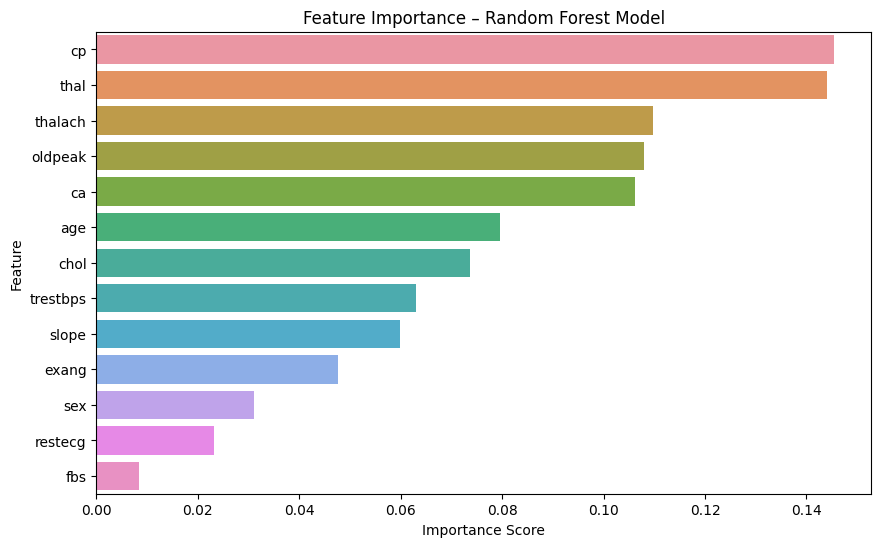

In [0]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df
)
plt.title("Feature Importance – Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# Compare model performance

In [0]:
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic_Regression,0.816667,0.84,0.75,0.933036
1,Random_Forest,0.816667,0.84,0.75,0.930804


# Visual comparison of ROC-AUC

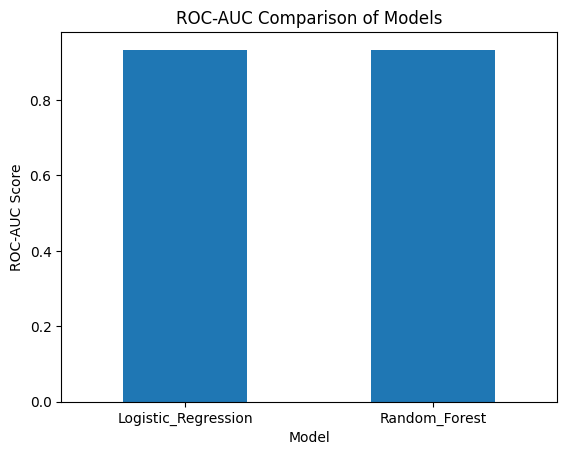

In [0]:

results_df.set_index("Model")["ROC-AUC"].plot(kind="bar")
plt.title("ROC-AUC Comparison of Models")
plt.ylabel("ROC-AUC Score")
plt.xticks(rotation=0)
plt.show()


# Grid Search for Random Forest

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [4, 6, 8],
    "classifier__min_samples_split": [2, 5]
}

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")


Best Parameters:
{'classifier__max_depth': 6, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV ROC-AUC: 0.9094


## Evaluate Tuned Model

In [0]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.88      0.75      0.81        28

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

Test ROC-AUC: 0.9386160714285714


## Log Tuned Model to MLflow

In [0]:
with mlflow.start_run(run_name="Random_Forest_Tuned"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob))
    mlflow.sklearn.log_model(best_model, "model")


2026/01/02 09:53:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://adb-7588343028506469.9.azuredatabricks.net/ml/experiments/1877251045227108/models/m-8676dc372945444199b8733d6215c85f?o=7588343028506469
2026/01/02 09:53:08 INFO mlflow.models.model: Model logged without a signature. Signatures are required for Databricks UC model registry as they validate model inputs and denote the expected schema of model outputs. Please set `input_example` parameter when logging the model to auto infer the model signature. To manually set the signature, please visit https://www.mlflow.org/docs/3.8.1/ml/model/signatures.html for instructions on setting signature on models.


# Cross validation

In [0]:
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    cv_score = cross_val_score(
        pipeline,
        X,
        y,
        cv=5,
        scoring="roc_auc"
    ).mean()

    print(f"{model_name} CV ROC-AUC: {cv_score:.4f}")


Logistic_Regression CV ROC-AUC: 0.9043
Random_Forest CV ROC-AUC: 0.9048


# Model selection summary

## Model Selection Summary

- Logistic Regression served as a strong baseline model.
- Random Forest consistently achieved higher ROC-AUC, Precision, and Recall.
- Random Forest was selected for deployment due to its superior performance and ability to capture non-linear relationships.


# Register Best Model

In [0]:
# Register best model manually from MLflow UI as Production
print("Register the best model in MLflow Model Registry as 'Production'")


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-8586304272834667>, line 2
      1 results_df.set_index("Model")["ROC-AUC"].plot(kind="bar")
----> 2 plt.title("ROC-AUC Comparison of Models")
      3 plt.ylabel("ROC-AUC Score")
      4 plt.xticks(rotation=0)

NameError: name 'plt' is not defined